In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Deep LEarning
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation, Dropout, Dense, Masking
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D

In [ ]:
#load the dataset
#dataset1_path = '/content/drive/MyDrive/Colab Notebooks/players_tweet_preprocessed_data (1).csv'
#dataset2_path = '/content/drive/MyDrive/Colab Notebooks/preprocessed_airlines_data.csv'

tweet_airline_sentiment = pd.read_csv('preprocessed_airlines_data.csv')
tweet_player_sentiment = pd.read_csv('players_preprocessed_data.csv')

In [4]:
tweet_player_sentiment

,Unnamed: 0,tweet_text,sentiment,tokens
0,8,fantastic signing worth every single penny,positive,"['fantastic', 'signing', 'worth', 'every', 'si..."
1,9,need keep get compliment,neutral,"['need', 'keep', 'get', 'compliment']"
2,13,absolute wanker human hope goid night hahahaha...,negative,"['absolute', 'wanker', 'human', 'hope', 'goid'..."
3,16,absolute world class performance vote tap vote,positive,"['absolute', 'world', 'class', 'performance', ..."
4,17,congratulation signing expensive goalkeeper br...,positive,"['congratulation', 'signing', 'expensive', 'go..."
...,...,...,...,...
718685,1931324,sleep well ’ worry cuz ur team fucking shit,negative,"['sleep', 'well', '’', 'worry', 'cuz', 'ur', '..."
718686,1931329,left ethan home ´ 18 yet,neutral,"['left', 'ethan', 'home', '´', '18', 'yet']"
718687,1931330,google daniel “ twitch ” franco jayz,neutral,"['google', 'daniel', '“', 'twitch', '”', 'fran..."
718688,1931331,mum pig asshole,negative,"['mum', 'pig', 'asshole']"


In [5]:
# Change the column names
new_column_names = ['Unnamed: 0','text', 'airline_sentiment','tokens']
tweet_player_sentiment.columns = new_column_names

# Append dataset 10-14 to dataset 1-10
sentiment_data = tweet_airline_sentiment.append(tweet_player_sentiment)

# Optional: Reset the index of the merged dataset
sentiment_data = sentiment_data.reset_index(drop=True)

# Rename a single column
sentiment_data.rename(columns={'airline_sentiment': 'sentiment'}, inplace=True)

sentiment_data = sentiment_data.drop('Unnamed: 0', axis=1)

<AxesSubplot:xlabel='sentiment', ylabel='count'>

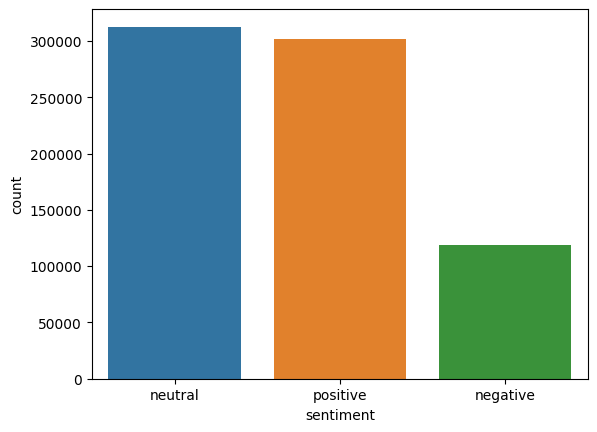

In [6]:
import seaborn as sns

sns.countplot(x=sentiment_data['sentiment'], data=sentiment_data)

In [7]:
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733330 entries, 0 to 733329
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       731077 non-null  object
 1   sentiment  733330 non-null  object
 2   tokens     733330 non-null  object
dtypes: object(3)
memory usage: 16.8+ MB


In [8]:
train_X,test_X,train_y,test_y = train_test_split(sentiment_data['text'], sentiment_data['sentiment'], test_size=0.1, random_state=44)

In [9]:
# Encode the sentiment labels
label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(train_y)
test_y  = label_encoder.fit_transform(test_y)

In [10]:
tokenizer = Tokenizer()
# Convert any float values to strings
sentiment_data.text = sentiment_data.text.astype(str)
tokenizer.fit_on_texts(sentiment_data.text)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
print(f"Word index length: {len(tokenizer.word_index)}")

In [12]:
# Initialize the max length to the first tweet length
max_length = len(sentiment_data["text"].iloc[0].split())

# Loop through the tweets
for tweet in sentiment_data["text"]:
    # Get each tweet's length
    length = len(tweet.split())
    # Update the max length if greater
    if length > max_length:
        max_length = length

print(f"Maximum token length: {max_length}")


Maximum token length: 84


In [13]:
# Training set
sequences_train = tokenizer.texts_to_sequences([str(text) for text in train_X])
# Test set
sequences_test = tokenizer.texts_to_sequences([str(text) for text in test_X])


In [14]:
# Pad the training sequences to the same length after the sequence
train_X = pad_sequences(sequences_train, maxlen=max_length, padding="post")
# Pad the test sequences to the same length after the sequence
test_X = pad_sequences(sequences_test, maxlen=max_length, padding="post")

# Setup the training target
train_y = train_y
# Setup the test target values
test_y = test_y

print(f"Training test shape : {train_X.shape}")

Training test shape : (659997, 84)


In [15]:
embeddings_dictionary = dict()
embedding_dimension = 100
glove_file = open("word_embeddings.txt")

In [16]:
import codecs

# Open the GloVe file with the correct encoding
with codecs.open('word_embeddings.txt', 'r', encoding='utf-8') as glove_file:
    # Iterate through the file
    for line in glove_file:
        # Split each line
        records = line.split()
        # Get the actual word
        word = records[0]
        # Get the dimensional representation
        representation = np.asarray(records[1:], dtype="float32")
        # Update the words dictionary 
        embeddings_dictionary[word] = representation

# Initialize the embedding_matrix
embeddings_matrix = np.zeros((vocab_size, embedding_dimension))

# Iterate through the tokenizer words list
for word, index in tokenizer.word_index.items():
    # Get the word representation
    embedding_vector = embeddings_dictionary.get(word)
    # Update the word representation if it exists in our dictionary
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector
